In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/stepik/m3. unsupervised/w4. topic modeling/4.4 bigartm demo'
!ls

/content/drive/MyDrive/Colab Notebooks/stepik/m3. unsupervised/w4. topic modeling/4.4 bigartm demo
 batches
 bigartm.bb7a49510e4c.invalid-user.log.INFO.20210508-120226.59
 bigartm.bb7a49510e4c.invalid-user.log.WARNING.20210508-121817.59
 bigartm.INFO
 bigartm.ipynb
'bigartm - original.ipynb'
 bigartm.WARNING
 school.txt


In [ ]:
import os
from matplotlib import pyplot as plt
import pprint
%matplotlib inline

In [ ]:
!pip install bigartm

     |████████████████████████████████| 1.9MB 5.0MB/s 


In [ ]:
import artm
%pip show bigartm

Name: bigartm
Version: 0.9.2
Summary: BigARTM: the state-of-the-art platform for topic modeling
Home-page: https://github.com/bigartm/bigartm
Author: None
Author-email: None
License: New BSD license
Location: /usr/local/lib/python3.7/dist-packages
Requires: pandas, numpy, tqdm, protobuf
Required-by: 


In [ ]:
batch_folder = 'batches'
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder=batch_folder, 
                                        batch_size=100)

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batch_vectorizer.data_path)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [ ]:
topic_names = [f'topic_{i}' for i in range(15)]
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True)

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model_artm.scores.add(artm.TopTokensScore(name="TopTokensScore", num_tokens=15, class_id="text"))

model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15))

model_artm.initialize(dictionary=dictionary)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=6)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

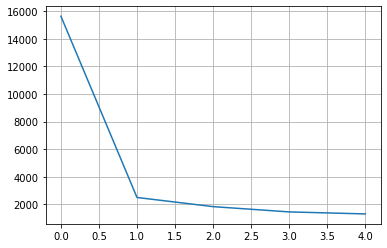

In [ ]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)
plt.grid()
plt.show()

Выведем топы слов:

In [ ]:
tokens = model_artm.score_tracker["TopTokensScore"].tokens[-1]

for topic_name in model_artm.topic_names:
    print(topic_name, ': ', tokens[topic_name])

topic_0 :  ['быть', 'русский', 'для', 'что', 'они', 'язык', 'время', 'свой', 'это', 'как', 'человек', 'ребенок', 'мочь', 'его', 'век']
topic_1 :  ['что', 'свой', 'который', 'быть', 'это', 'ядро', 'герой', 'она', 'они', 'этот', 'его', 'атом', 'как', 'такой', 'образ']
topic_2 :  ['что', 'который', 'быть', 'как', 'это', 'для', 'этот', 'такой', 'его', 'два', 'свет', 'один', 'они', 'или', 'так']
topic_3 :  ['что', 'это', 'вода', 'этот', 'тело', 'который', 'океан', 'уравнение', 'как', 'ядро', 'такой', 'они', 'температура', 'гора', 'мочь']
topic_4 :  ['пушкин', 'поэт', 'что', 'который', 'это', 'стихотворение', 'свой', 'лирика', 'этот', 'век', 'год', 'быть', 'произведение', 'как', 'такой']
topic_5 :  ['быть', 'x', 'при', 'функция', 'число', 'этот', 'сила', 'это', 'для', 'ток', 'что', 'энергия', 'точка', 'если', 'f']
topic_6 :  ['человек', 'свой', 'который', 'что', 'жизнь', 'его', 'герой', 'быть', 'это', 'как', 'этот', 'произведение', 'она', 'они', 'себя']
topic_7 :  ['который', 'человек', 'век

Давайте посмотрим также на разреженность матриц:

In [ ]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [ ]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary_name="dictionary"))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)

Попробуем менять коэффициент регуляризации:

In [ ]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)

In [ ]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
        print word,
    print

In [ ]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [ ]:
model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [ ]:
phi = model_artm.get_phi()

In [ ]:
phi.shape

(16099, 15)

Матрица вероятностей тем в документах.

In [ ]:
theta = model_artm.get_theta()
theta

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [ ]:
theta_test = model_artm.transform(batch_vectorizer, num_document_passes=10)